In [81]:
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time, TimezoneInfo
import astropy.units as u
from astropy.visualization import time_support
from astropy.table import Table

import photutils
from photutils.aperture import ApertureStats

from timdimm_tng.ser import load_ser_file
from timdimm_tng.analyze_cube import find_apertures, moments, seeing, analyze_dimm_cube

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x1685d91d0>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [13]:
qe_tab = Table.read("~/MMT/timdimm_tng/notebooks/asi432mm_qe.csv", format="ascii.csv", names=["wavelength", "qe"])
np.sum(qe_tab["qe"] * qe_tab["wavelength"]) /np.sum(qe_tab["qe"])

639.375040081782

In [16]:
206265 * 9e-6 / 2.5

0.7425539999999999

In [17]:
plt.close('all')

In [68]:
testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-21-31.ser"
#testfile = Path.home() / "SAAO/timdimm_data/indi_2023-06-24/indi_record_2023-06-24@18-18-32.ser"
#d = load_ser_file(testfile)

In [44]:
d.keys()

dict_keys(['filename', 'file_id', 'lu_id', 'color_id', 'nplanes', 'littleendian', 'im_width', 'im_height', 'pix_depth_per_plane', 'bytes_per_pixel', 'nframe', 'observer', 'instrument', 'telescope', 'dateobs', 'dateobs_utc', 'data', 'frame_times'])

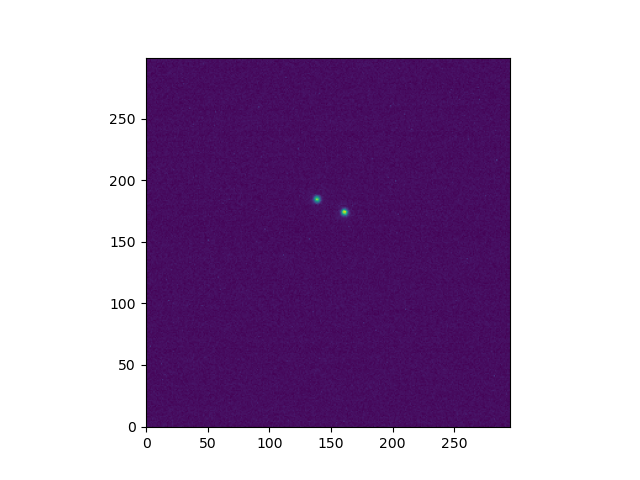

In [45]:
fig, ax = plt.subplots()
ax.imshow(d["data"][100], origin="lower")
plt.show()

In [46]:
aps = find_apertures(d['data'][2000])
ap_stats = ApertureStats(d['data'][2000], aps[0])
ap_stats.centroid

array([[137.5021171 , 194.29872974],
       [160.9780894 , 182.371896  ]])

In [69]:
airmass = 1/np.cos(90 * u.deg - 62 * u.deg)
results = analyze_dimm_cube(testfile, airmass=airmass, plot=False)
print(f'{results["seeing"].value:.2f}')
results["seeing"] 

/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/Users/tim/conda/envs/timdimm/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


1.02


<Quantity 1.02160555 arcsec>

In [67]:
airmass

<Quantity 1.13257005>

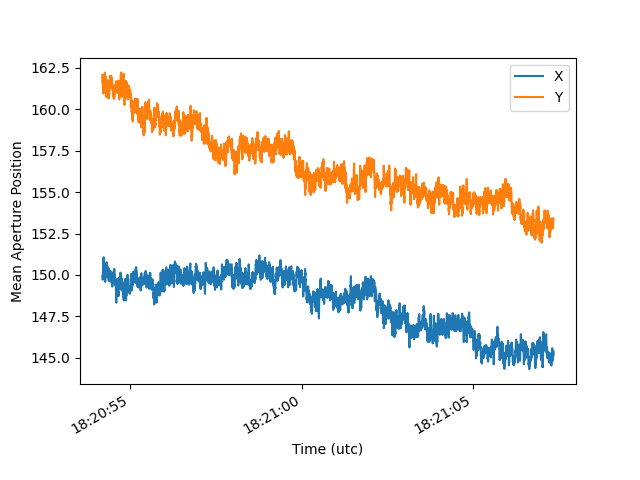

In [70]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["aperture_positions"][0], label='X')
ax.plot(results["frame_times"], results["aperture_positions"][1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

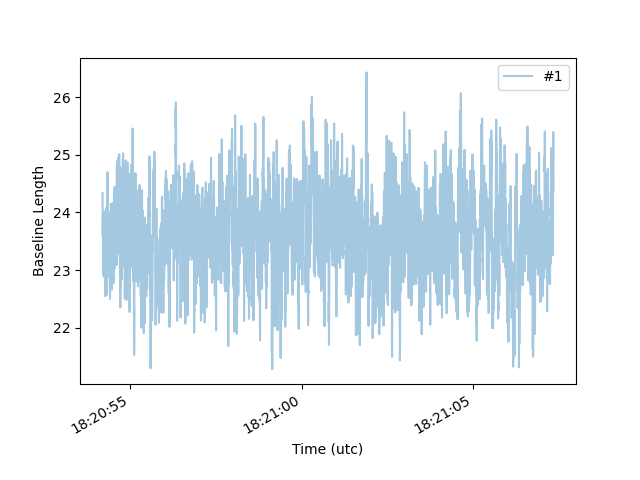

In [71]:
fig, ax = plt.subplots()
ax.plot(results["frame_times"], results["baseline_lengths"][0], label='#1', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

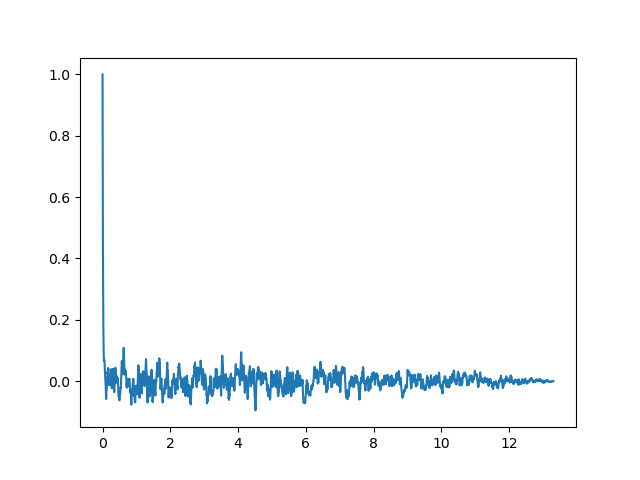

In [72]:
b0 = results["baseline_lengths"][0] - results["baseline_lengths"][0].mean()
dt = (results["frame_times"][1] - results["frame_times"][0]).to_value('sec')
autocor = np.correlate(b0, b0, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()

In [77]:
tobs = results['frame_times'][-1]

In [76]:
print(f'{results["seeing"]:.2f}')

1.02 arcsec


In [82]:
print(tobs.to_datetime(timezone=TimezoneInfo(utc_offset=2 * u.hour)))

2023-06-24 20:21:07.338829+02:00


In [87]:
from bs4 import BeautifulSoup
import requests

In [96]:
page = requests.get("https://suthweather.saao.ac.za/")
soup = BeautifulSoup(page.content, 'html.parser')

In [103]:
def hex2bin(str):
    """
    take a hexadecimal number as a string and convert it to a binary string
    """
    bin = [
        '0000', '0001', '0010', '0011',
        '0100', '0101', '0110', '0111',
        '1000', '1001', '1010', '1011',
        '1100', '1101', '1110', '1111'
    ]
    aa = ''
    for i in range(len(str)):
        aa += bin[int(str[i], base=16)]
    return aa

def checksum(str):
    """
    twos complement checksum as used by the ox wagon PLC
    """
    command = str[1:len(str) - 4]
    sum = 0
    for i in range(0, len(command), 2):
        byte = command[i] + command[i + 1]
        sum = sum + int(byte, base=16)
    neg = ~sum & 0xFF
    return neg + 1


In [106]:
checksum(':01101064000408' + '0000')

111